# Treinando Corpus VODAN BR

## Importando bibliotecas

In [1]:
import sys
import re
import unicodedata
import multiprocessing
import random

import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.similarities import WmdSimilarity
from pyemd import emd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import nltk
from nltk.corpus import stopwords

import numpy as np
import scipy as sp
import pandas as pd

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

np.random.seed(0)
random.seed(0)

## Lendo o arquivo de entrada

In [2]:
data = pd.read_csv('Dados/anamnese.csv')
data.head()

,anamnese
0,#Admissão pela clinica médica \r\n# Paciente f...
1,"Paciente proveniente da residência, foi atendi..."
2,EVOLUÇÃO FISIOTERAPIA - PLANTÃO DIURNO SEGUNDA...
3,"Paciente do sexo feminino, 20 anos, acometida ..."
4,# ADMISSÃO COORTE COVID-19 #\r\n\r\n- 41...


## Baixando stopwords em Português

In [3]:
stopwords_list = stopwords.words('portuguese')
stopwords_list[:10]

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um']

## Limpando os dados

In [4]:
def clean_data(word):
    word = word.lower()
    word = re.sub(r'[^\w\s]','', word)
    word = re.sub(r"([0-9])", r" ", word)
    
    words = word.split() 
    
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    
    return " ".join(clean_words)

In [5]:
clean_text = []

for text in data['anamnese']:
    clean_text.append(clean_data(text))

data['clean_text'] = clean_text
data.head()

,anamnese,clean_text
0,#Admissão pela clinica médica \r\n# Paciente f...,admissão clinica médica paciente feminina anos...
1,"Paciente proveniente da residência, foi atendi...",paciente proveniente residência atendida spa i...
2,EVOLUÇÃO FISIOTERAPIA - PLANTÃO DIURNO SEGUNDA...,evolução fisioterapia plantão diurno segunda f...
3,"Paciente do sexo feminino, 20 anos, acometida ...",paciente sexo feminino anos acometida tipo hep...
4,# ADMISSÃO COORTE COVID-19 #\r\n\r\n- 41...,admissão coorte covid anos srag suspeita covid...


In [6]:
data_clean_text = data['clean_text'].values.tolist()

word_split = []
for word in data_clean_text:
    word_split.append(word.split(' '))

data_clean_text = word_split

## Selecionando apenas palavras distintas

In [7]:
def distinct_words(corpus):
    corpus_words = []
    num_corpus_words = -1
    
    corpus_words =  sorted(list(set([word for sentence in corpus for word in sentence])))
    num_corpus_words = len(corpus_words)

    return corpus_words, num_corpus_words

## Calculando matriz de co-ocorrência

In [8]:
def compute_co_occurrence_matrix(corpus, window_size = 5):
    words, num_words = distinct_words(corpus)
    M = np.zeros((num_words, num_words))
    word2ind = dict([(word, index) for index, word in enumerate(words)])
    
    for sentence in corpus:
        current_index = 0
        sentence_len = len(sentence)
        indices = [word2ind[i] for i in sentence]
        
        while current_index < sentence_len:
            left  = max(current_index - window_size, 0)
            right = min(current_index + window_size + 1, sentence_len) 
            
            current_word = sentence[current_index]
            current_word_index = word2ind[current_word]
            words_around = indices[left:current_index] + indices[current_index+1:right]
            
            for ind in words_around:
                M[current_word_index, ind] += 1
            
            current_index += 1

    return M, word2ind

## Reduzindo a matriz de coorrência para k-dimensão

In [9]:
def reduce_to_k_dim(M, k = 2):
    n_iters = 10    
    M_reduced = None
    
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    TSVD = TruncatedSVD(n_components = k, n_iter = n_iters)
    M_reduced = TSVD.fit_transform(M)
    
    print("Done.")
    return M_reduced

## Plotando embeddings

In [10]:
def plot_embeddings(M_reduced, word2ind, words):
    for word in words:
        index = word2ind[word]
        embedding = M_reduced[index]
        
        x, y  = embedding[0], embedding[1]
        
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)
    
    plt.show()

Running Truncated SVD over 1846 words...
Done.


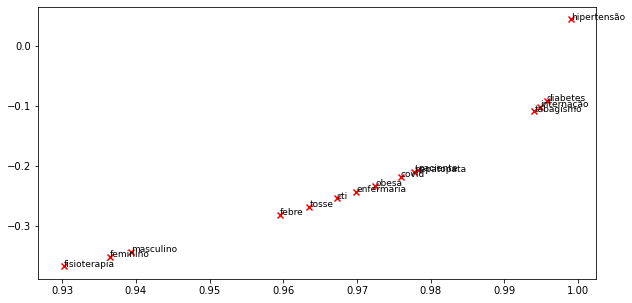

In [11]:
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(data_clean_text)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence)

M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis = 1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis]

words = [
    'paciente', 'covid', 'feminino', 'masculino',
    'febre', 'obesa', 'tabagismo', 'diabetes', 'tosse', 'hepatopata', 'hipertensão',
    'fisioterapia', 'enfermaria', 'internação', 'cti'
]

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

## Criando um modelo vazio

In [12]:
cores = multiprocessing.cpu_count()

model = Word2Vec(
    min_count = 10,
    window = 5,
    workers = cores - 1,
    max_vocab_size = 100000
)

model.build_vocab(data_clean_text)

## Treinando o modelo

In [13]:
model.train(
    data_clean_text,
    total_examples = model.corpus_count,
    epochs = 50
)

(55317, 306750)

In [14]:
words = list(model.wv.index_to_key)
words[:10]

['paciente',
 'anos',
 'covid',
 'nega',
 'dias',
 'uso',
 'febre',
 'conduta',
 'mmhg',
 'dia']

In [15]:
model.save('Anamnese')

In [16]:
trained_model = gensim.models.Word2Vec.load('Anamnese')

In [17]:
trained_model.wv.most_similar('paciente')

[('sintomas', 0.9965553879737854),
 ('covid', 0.9942978620529175),
 ('febre', 0.993326723575592),
 ('seca', 0.9928711652755737),
 ('tosse', 0.9925109148025513),
 ('início', 0.9917367100715637),
 ('quadro', 0.991161584854126),
 ('cti', 0.991116464138031),
 ('hospital', 0.9907221794128418),
 ('tratamento', 0.9902929067611694)]

In [18]:
trained_model.wv.most_similar(positive = ['paciente', 'covid'], negative = ['febre'])

[('feminino', 0.9956920742988586),
 ('sexo', 0.9948996901512146),
 ('cti', 0.992834210395813),
 ('suspeita', 0.9893884658813477),
 ('enfermaria', 0.9888049364089966),
 ('internação', 0.988092303276062),
 ('síndrome', 0.9868777990341187),
 ('admitido', 0.9861096739768982),
 ('plantão', 0.9860779643058777),
 ('proveniente', 0.9812664985656738)]